# Predicting Red Wine Quality

In this notebook we will explore a dataset containing information on red wine samples. The data includes physicochemical variables along with sensory variables (quality ratings), and is made available through the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/wine+quality) [1].

## Import packages

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

# data analysis
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tabulate import tabulate

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

## Exploring the data

First we import the data from our `.csv` file and split it into separate training/test datasets. The test set is only used for the final evaluation and not for any data analysis or model training.

In [2]:
data = pd.read_csv('./red-wine-quality-data.csv')
X, y = data.iloc[:,:-1], data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)
train = pd.concat([X_train, y_train], axis=1)

Our data conveniently comes pre-cleaned, so we can jump right into exploring the dataset.

First, we take a look at the distribution of the wine quality ratings. 

<AxesSubplot:xlabel='quality', ylabel='Probability'>

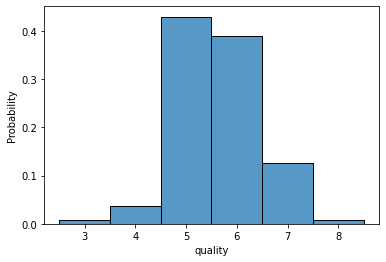

In [3]:
sns.histplot(data=y_train, stat='probability', discrete=True)

From the bar chart we can see that the majority of the wines in the dataset are rated at a 5 or 6. This dataset is imbalanced, as there are many more "average" wines than there are "excellent" or "poor" wines. You can read more about dealing with imbalanced data [here](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/), but for this notebook we will ignore the imbalance and move on with our analysis.

Let's take a deeper look at our training dataset.

In [4]:
X_train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000
mean,8.351212,0.529359,0.273628,2.586669,0.088082,15.985927,46.806099,0.996791,3.308436,0.658202,10.411493
std,1.751877,0.177778,0.195918,1.513554,0.048498,10.695301,33.250148,0.001891,0.155220,0.174127,1.056506
min,4.700000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.100000,0.392500,0.100000,1.900000,0.071000,7.000000,22.000000,0.995660,3.200000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.080000,14.000000,38.000000,0.996800,3.310000,0.620000,10.200000
75%,9.250000,0.640000,0.430000,2.600000,0.091000,22.000000,63.000000,0.997890,3.400000,0.730000,11.100000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000


We have 11 numerical features. Let's plot the probability density for each feature for a visual overview of the features.

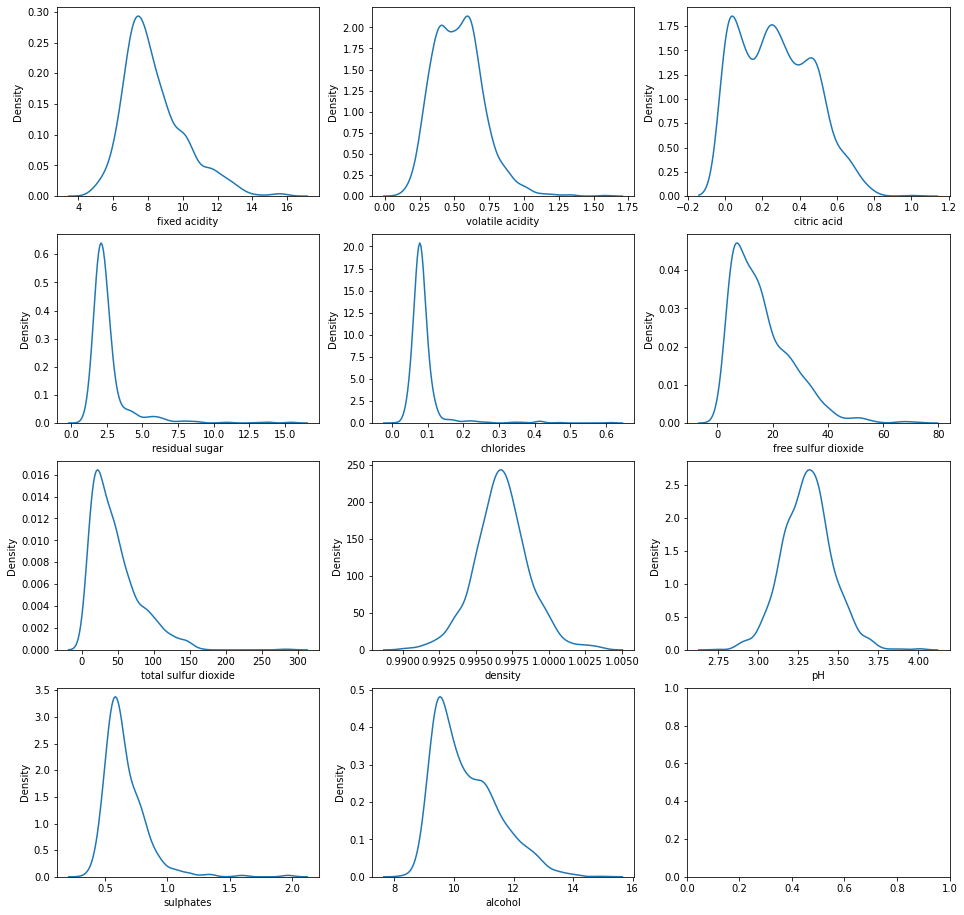

In [5]:
n_rows=4
n_cols=3
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16,16))

for i, column in enumerate(X_train.columns):
    sns.kdeplot(X_train[column], ax=axes[i//n_cols,i%n_cols])

While these plots give us a good visual of the distribution of values for each feature, we'd especially like to see how each feature correlates to the overall quality. Let's re-plot each feature, except this time let's split the distributions into "good" and "bad" samples to see if the distributions of each variable look any different when split by "good vs. bad" quality.

Our data source specifies that ratings 7 or above are considered "good", so let's divide our variable as such.

In [6]:
def IsRatingGood(rating):
    if (rating > 6.5):
        return "good"
    else:
        return "bad"

y_train_binary = y_train.map(IsRatingGood)
y_test_binary = y_test.map(IsRatingGood) # also convert our test set labels

y_train_binary.value_counts()

bad     1106
good     173
Name: quality, dtype: int64

Next we will plot the probability distribution for each variable, separated by "good" or "bad" quality.

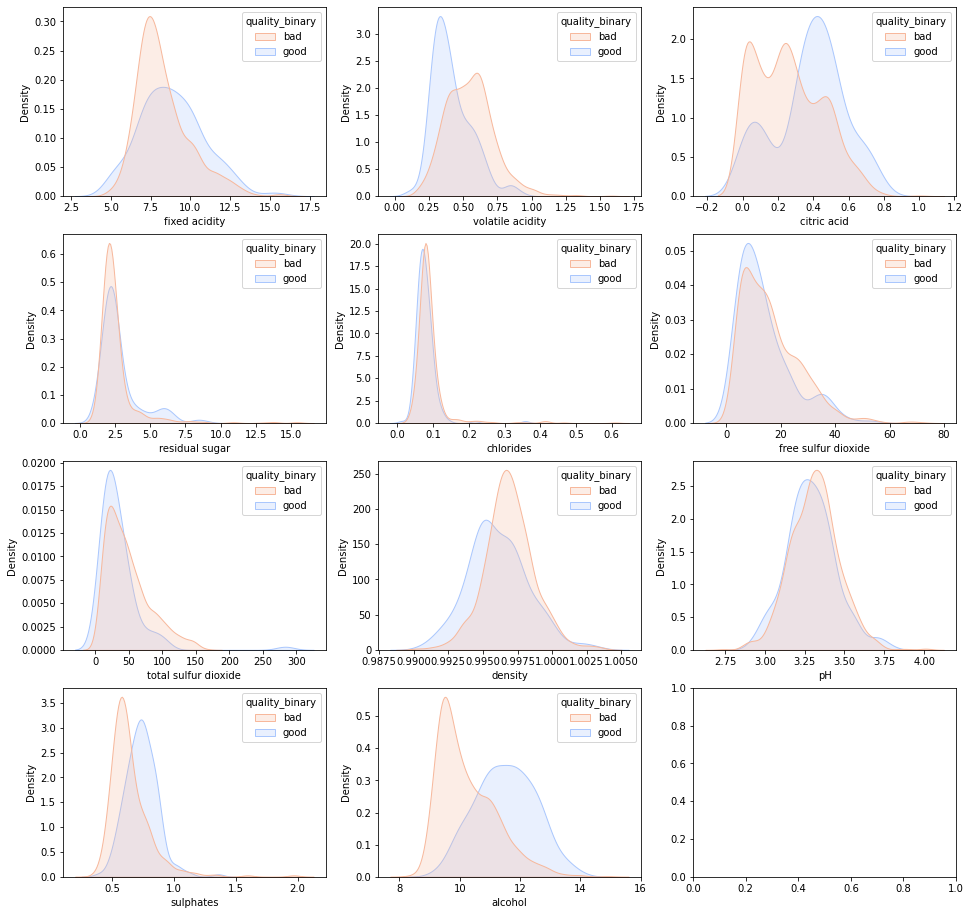

In [7]:
train['quality_binary'] = y_train_binary

n_rows=4
n_cols=3
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16,16))

for i, column in enumerate(X_train.columns):
    sns.kdeplot(
        data=train, x=column, hue='quality_binary', 
        common_norm=False, fill=True, palette='coolwarm_r',
        ax=axes[i//n_cols,i%n_cols]
    )

Here we're looking for features where there is a visible difference between the "good" and "bad" distributions. Features with clear differences in the two probability distributions are likely to be useful in predicting the quality. On the other hand, features where the two distributions look nearly identical likely do not offer much predictive value. 

We notice significant differences in the distributions for the following features:
* fixed acidity
* volatile acidity
* citric acid
* density
* sulphates
* alcohol

For the following features, there are some minor differences in the distributions:
* residual sugar - both distributions peak around the same mean (2.5), but "good" wines are slightly more likely to have a value around `6`
* chlorides - the two distributions look nearly identical, indicating this feature has little predictive value on its own
* free sulfur dioxide - the two distributions look similar but with small differences along the upper tails of the plots
* total sulfur dioxide - the two distributions look similar, however the "good" wines have a smaller variance than the "bad" wines
* pH - the two distributions look nearly identical, indicating this feature has little predictive value on its own



## Predicting quality

Now that we've taken a look at the data we are dealing with, let's build a binary classifier to predict if a given wine is "good" or "bad".

First, let's normalize our features using a `MinMaxScaler` transformation to make sure all the features are on a common scale.

In [8]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Our datasets are now ready to build our machine learning models. We will train three different classifiers and compare the accuracy scores for each:
- Random Forest
- Logistic Regression
- k-Nearest Neighbor

For each classifier, we will train both the base model (default hyperparameters) as well as a model with its hyperparameters tuned using cross-validation. Since our data is imbalanced, we will use the area under the ROC curve (ROC AUC) as our evaluation metric.

Let's build our models.

### Random Forest Classifier

In [9]:
# Hyperparameter distributions for cross-validation
rfc_param_grid = {
    'n_estimators': [int(x) for x in np.linspace(10, 2000, num=25)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(1, 100, num=25)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rfc = RandomForestClassifier(random_state=0)
rfc_tuned = RandomizedSearchCV(estimator=rfc, param_distributions=rfc_param_grid, scoring='roc_auc', n_iter=100, random_state=0, n_jobs=-1)

rfc.fit(X_train, y_train_binary)
rfc_tuned.fit(X_train, y_train_binary)
print('best_params = ', rfc_tuned.best_params_)
print('best_score = ', rfc_tuned.best_score_)

best_params =  {'n_estimators': 839, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 58, 'bootstrap': False}
best_score =  0.9093452616462997


### Logistic Regression Classifier

In [10]:
lrc_param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': 2.0**np.arange(-10,10),
} 

lrc = LogisticRegression(random_state=0)
lrc_tuned = RandomizedSearchCV(estimator=lrc, param_distributions=lrc_param_grid, scoring='roc_auc', n_iter=100, random_state=0)

lrc.fit(X_train, y_train_binary)
lrc_tuned.fit(X_train, y_train_binary)
print('best_params = ', lrc_tuned.best_params_)
print('best_score = ', lrc_tuned.best_score_)

best_params =  {'solver': 'lbfgs', 'penalty': 'l2', 'C': 2.0}
best_score =  0.8630783721095139


### k-Nearest Neighbor Classifier

In [11]:
knn_param_grid = {
    'n_neighbors': np.arange(1,31),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
} 

knn = KNeighborsClassifier()
knn_tuned = RandomizedSearchCV(estimator=knn, param_distributions=knn_param_grid, scoring='roc_auc', n_iter=100, random_state=0, n_jobs=-1)

knn.fit(X_train, y_train_binary)
knn_tuned.fit(X_train, y_train_binary)
print('best_params = ', knn_tuned.best_params_)
print('best_score = ', knn_tuned.best_score_)

best_params =  {'weights': 'distance', 'n_neighbors': 26, 'algorithm': 'ball_tree'}
best_score =  0.8967444177132758


### Evaluating our trained models

At this stage we are evaluating our trained models using our test dataset. For each classifier, we are measuring both the ROC AUC and accuracy scores of the base model and tuned model.

In [12]:
def get_scores(model_name, base_model, model, X_test, y_test):
    base_auc = roc_auc_score(y_true=y_test, y_score=base_model.predict_proba(X_test)[:, 1])
    tuned_auc = roc_auc_score(y_true=y_test, y_score=model.predict_proba(X_test)[:, 1])
    base_acc = accuracy_score(y_true=y_test, y_pred=base_model.predict(X_test))
    tuned_acc = accuracy_score(y_true=y_test, y_pred=model.predict(X_test))
    return [model_name, str(round(base_auc, 4)) + " / " + str(round(base_acc, 4)), str(round(tuned_auc, 4)) + " / " + str(round(tuned_acc, 4))]

results = []
keys = ['Classifier', 'Base Model AUC / Accuracy', 'Tuned Model AUC / Accuracy']
results.append(get_scores('Random Forest', rfc, rfc_tuned, X_test, y_test_binary))
results.append(get_scores('Logistic Regression', lrc, lrc_tuned, X_test, y_test_binary))
results.append(get_scores('k-Nearest Neighbors', knn, knn_tuned, X_test, y_test_binary))

print(tabulate(results, headers=keys, colalign=('left', 'center', 'center')))

Classifier            Base Model AUC / Accuracy    Tuned Model AUC / Accuracy
-------------------  ---------------------------  ----------------------------
Random Forest              0.9579 / 0.9281              0.9587 / 0.9281
Logistic Regression        0.8892 / 0.8656              0.8935 / 0.8781
k-Nearest Neighbors        0.8523 / 0.8781              0.9365 / 0.9062


We've summarized our results in a table, and it is clear that all of our trained classifier models perform relatively well on our test data. The clear winner however is our hyperparameter-tuned Random Forest Classifier model, with a ROC AUC score of `0.9587` and accuracy score of `0.9281`. 

## References

[1] P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.